In [1]:
import math

import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

import flax
import optax
from flax import linen as nn
from flax.training import train_state

class Transformer(nn.Module):
    num_heads: int
    embed_dim: int
    num_layers: int
    output_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.embed_dim)(x)
        for _ in range(self.num_layers):
            x = nn.SelfAttention(num_heads=self.num_heads)(x)
            x = nn.LayerNorm()(x)
        x = nn.Dense(self.output_dim)(x)
        return x

def create_dataset(rng, num_samples=1000, input_dim=10, output_dim=1):
    x_rng, y_rng = random.split(rng)
    X = random.normal(x_rng, (num_samples, input_dim))
    true_weights = random.normal(y_rng, (input_dim, output_dim))
    y = jnp.dot(X, true_weights) + random.normal(y_rng, (num_samples, output_dim)) * 0.1  # Add noise
    return X, y

class TrainState(train_state.TrainState):
    batch_stats: flax.core.FrozenDict

def create_train_state(rng, model, learning_rate):
    params_rng, dropout_rng = random.split(rng)
    params = model.init({"params": params_rng}, jnp.ones((1, X.shape[1])))["params"]
    tx = optax.adam(learning_rate)
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx, batch_stats={})

def compute_loss(params, apply_fn, x, y):
    preds = apply_fn({"params": params}, x)
    loss = jnp.mean((preds - y) ** 2)  # MSE loss
    return loss

@jax.jit
def train_step(state, x, y):
    def loss_fn(params):
        return compute_loss(params, state.apply_fn, x, y)

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

def train_model(state, X, y, num_epochs=100, batch_size=32):
    num_batches = math.ceil(X.shape[0] / batch_size)
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i in range(num_batches):
            batch_start = i * batch_size
            batch_end = batch_start + batch_size
            x_batch, y_batch = X[batch_start:batch_end], y[batch_start:batch_end]
            state, loss = train_step(state, x_batch, y_batch)
            epoch_loss += loss
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss / num_batches:.4f}")
    return state

# Seeding for random operations
main_rng = random.PRNGKey(42)

main_rng, dataset_rng = random.split(main_rng)
X, y = create_dataset(dataset_rng, input_dim=2)

model = Transformer(num_heads=2, embed_dim=16, num_layers=1, output_dim=y.shape[1])
state = create_train_state(main_rng, model, learning_rate=0.001)
state = train_model(state, X, y)

Epoch 1, Loss: 3.2789
Epoch 2, Loss: 0.6831
Epoch 3, Loss: 0.5905
Epoch 4, Loss: 0.5366
Epoch 5, Loss: 0.4748
Epoch 6, Loss: 0.4058
Epoch 7, Loss: 0.3390
Epoch 8, Loss: 0.2903
Epoch 9, Loss: 0.2609
Epoch 10, Loss: 0.2423
Epoch 11, Loss: 0.2293
Epoch 12, Loss: 0.2191
Epoch 13, Loss: 0.2102
Epoch 14, Loss: 0.2020
Epoch 15, Loss: 0.1939
Epoch 16, Loss: 0.1855
Epoch 17, Loss: 0.1773
Epoch 18, Loss: 0.1695
Epoch 19, Loss: 0.1619
Epoch 20, Loss: 0.1536
Epoch 21, Loss: 0.1447
Epoch 22, Loss: 0.1360
Epoch 23, Loss: 0.1283
Epoch 24, Loss: 0.1220
Epoch 25, Loss: 0.1171
Epoch 26, Loss: 0.1133
Epoch 27, Loss: 0.1103
Epoch 28, Loss: 0.1079
Epoch 29, Loss: 0.1059
Epoch 30, Loss: 0.1043
Epoch 31, Loss: 0.1029
Epoch 32, Loss: 0.1018
Epoch 33, Loss: 0.1008
Epoch 34, Loss: 0.0999
Epoch 35, Loss: 0.0992
Epoch 36, Loss: 0.0985
Epoch 37, Loss: 0.0980
Epoch 38, Loss: 0.0975
Epoch 39, Loss: 0.0970
Epoch 40, Loss: 0.0966
Epoch 41, Loss: 0.0962
Epoch 42, Loss: 0.0959
Epoch 43, Loss: 0.0956
Epoch 44, Loss: 0.09

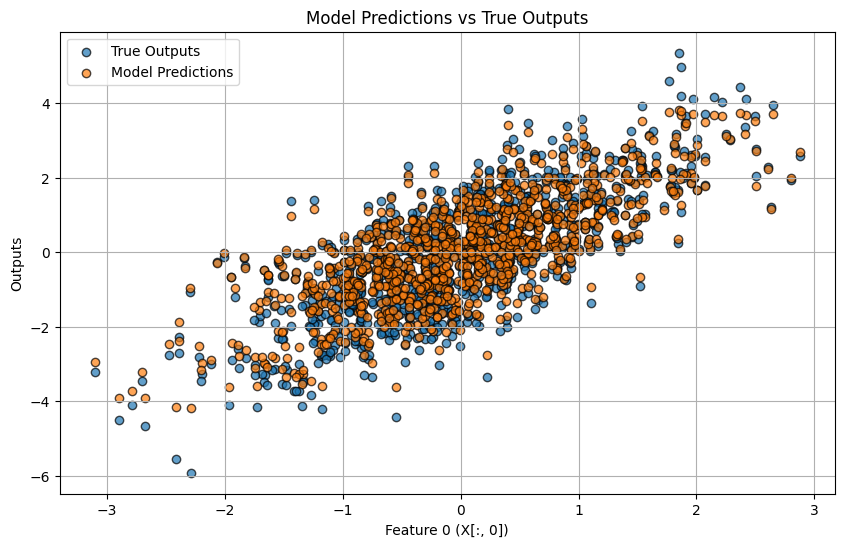

In [2]:
def visualize_data_predictions(X, y, preds=None, title="Data Visualization"):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], y, label="True Outputs", alpha=0.7, edgecolors="k")
    if preds is not None:
        plt.scatter(X[:, 0], preds, label="Model Predictions", alpha=0.7, edgecolors="k")
    plt.title(title)
    plt.xlabel("Feature 0 (X[:, 0])")
    plt.ylabel("Outputs")
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_model(state, X, y):
    # Generate predictions
    preds = state.apply_fn({"params": state.params}, X)
    visualize_data_predictions(X, y, preds, title="Model Predictions vs True Outputs")

evaluate_model(state, X, y)